In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import os
import json
from scipy import stats
from matplotlib.patches import Rectangle

In [ ]:
np.random.seed(42)
df_name = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/name_retrieval/evaluation_results/name_result_fin.csv')
for col in df_name.columns:
    if 'Precision' in col or 'Recall' in col or 'F1-Score' in col:
        df_name[col] = pd.to_numeric(df_name[col].astype(str).str.rstrip('%'), errors='coerce')

df_policy = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/policy_retrieval/final/policy_experiment_result.csv')
for col in ['Precision', 'Recall', 'F1-Score', 'Adjusted_Precision', 'Adjusted_Recall', 'Adjusted F1-Score']:
    if col in df_policy.columns:
        df_policy[col] = pd.to_numeric(df_policy[col].astype(str).str.rstrip('%'), errors='coerce')

df_policy['model_prompt'] = df_policy['Model'] + ' + ' + df_policy['Prompt']
payers = ['Aetna', 'BCBS_FEP', 'Cigna', 'UHC']

df_match = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/codes/analysis_figures/policy_match_rate_figure.csv')
df_match = df_match.dropna(subset=['Embedding_Model'])
df_match['Embedding_Model'] = df_match['Embedding_Model'].str.replace('Text-Embedding-[45]-small', 'Text-Embedding-3-small', regex=True)

df_qna = pd.read_csv('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/final_qna_results/final_file_updated.csv')
with open('/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/dataset/final_ground_truth.json', 'r') as f:
    ground_truth = json.load(f)

matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Helvetica', 'Arial']
matplotlib.rcParams['font.family'] = 'sans-serif'

Model-Prompt combinations: ['perplexity + baseline' 'perplexity + explicit' 'gpt4o-jun + baseline'
 'gpt4o-jun + explicit' 'gpt4o-oct + baseline' 'gpt4o-oct + explicit'
 'gpt5mini + baseline' 'gpt5mini + explicit']


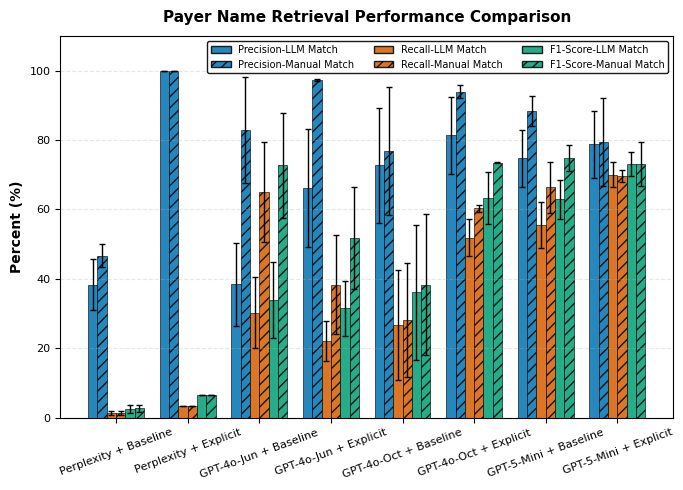

In [8]:
df_name['model_prompt'] = df_name['model'] + ' + ' + df_name['prompt']

model_prompts = df_name['model_prompt'].unique()
print("Model-Prompt combinations:", model_prompts)

def calc_stats(group, metric_prefix):
    precision = group[f'{metric_prefix} Precision (%)'].values
    recall = group[f'{metric_prefix} Recall (%)'].values
    f1 = group[f'{metric_prefix} F1-Score'].values
    
    precision = precision.astype(float)
    recall = recall.astype(float)
    f1 = f1.astype(float)

    return {
        'precision_mean': np.mean(precision),
        'precision_se': stats.sem(precision),
        'recall_mean': np.mean(recall),
        'recall_se': stats.sem(recall),
        'f1_mean': np.mean(f1),
        'f1_se': stats.sem(f1)
    }

results = {
    'Exact Match': [],
    'Regex Match': [],
    'LLM Match': [],
    'Manual Match': []
}

model_name_map = {'gpt5mini': 'GPT-5-Mini', 'gpt4o-jun': 'GPT-4o-Jun', 
                  'gpt4o-oct': 'GPT-4o-Oct', 'gpt4o': 'GPT-4o', 
                  'perplexity': 'Perplexity'}

for model_prompt in model_prompts:
    group = df_name[df_name['model_prompt'] == model_prompt]
    
    for match_type in ['LLM Match', 'Manual Match']:
        stats_dict = calc_stats(group, match_type)
        results[match_type].append(stats_dict)

precision_llm = [r['precision_mean'] for r in results['LLM Match']]
precision_manual = [r['precision_mean'] for r in results['Manual Match']]

recall_llm = [r['recall_mean'] for r in results['LLM Match']]
recall_manual = [r['recall_mean'] for r in results['Manual Match']]

f1_llm = [r['f1_mean'] for r in results['LLM Match']]
f1_manual = [r['f1_mean'] for r in results['Manual Match']]


precision_llm_se = [r['precision_se'] for r in results['LLM Match']]
precision_manual_se = [r['precision_se'] for r in results['Manual Match']]


recall_llm_se = [r['recall_se'] for r in results['LLM Match']]
recall_manual_se = [r['recall_se'] for r in results['Manual Match']]

f1_llm_se = [r['f1_se'] for r in results['LLM Match']]
f1_manual_se = [r['f1_se'] for r in results['Manual Match']]

fig, ax = plt.subplots(figsize=(7, 5))

base_colors = ['#0072B2', '#D55E00', '#009E73'] 
colors = [base_colors[0], base_colors[0], base_colors[1], base_colors[1], base_colors[2], base_colors[2]]
hatches = ['', '///', '', '///', '', '///']
labels = ['Precision-LLM Match', 'Precision-Manual Match', 'Recall-LLM Match', 'Recall-Manual Match', 'F1-Score-LLM Match', 'F1-Score-Manual Match']

x = np.arange(len(model_prompts))
width = 0.13

data_list = [
    (precision_llm, precision_llm_se),
    (precision_manual, precision_manual_se),
    (recall_llm, recall_llm_se),
    (recall_manual, recall_manual_se),
    (f1_llm, f1_llm_se),
    (f1_manual, f1_manual_se)
]

for i, ((means, ses), label, color, hatch) in enumerate(zip(data_list, labels, colors, hatches)):
    offset = (i - 2.5) * width
    bars = ax.bar(x + offset, means, width, color=color, 
                 alpha=0.85, hatch=hatch, edgecolor='black', linewidth=0.5,
                 yerr=ses, error_kw={'ecolor': 'black', 'capsize': 2.5, 'elinewidth': 1})

ax.set_ylabel('Percent (%)', fontsize=10, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"{model_name_map.get(mp.split(' + ')[0].lower(), mp.split(' + ')[0].title())} + {mp.split(' + ')[1].title()}" 
                    for mp in model_prompts], fontsize=8, rotation=20, ha='center')
ax.tick_params(axis='y', labelsize=8)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 110)

legend_elements = []
for label, color, hatch in zip(labels, colors, hatches):
    legend_elements.append(Rectangle((0, 0), 1, 1, fc=color, ec='black', 
                                     hatch=hatch, alpha=0.85, label=label))

ax.legend(handles=legend_elements, fontsize=7, loc='upper right', ncol=3, framealpha=0.9, edgecolor='black')
plt.title('Payer Name Retrieval Performance Comparison', fontsize=11, fontweight='bold', pad=10)
plt.tight_layout()
plt.savefig('Figure1.pdf', dpi=300, bbox_inches='tight')
plt.show()

  Aetna
Metric            GPT-4o + BaselineGPT-4o + KeywordGPT-4o + VerifiedGPT-5-Mini + BaselineGPT-5-Mini + KeywordGPT-5-Mini + Verified
----------------------------------------------------------------------
Precision             42.6±4.9     80.0±20.0    58.9±4.8     32.9±4.4     39.2±0.8     35.4±1.0 
Adj Precision         88.9±6.4    100.0±0.0    100.0±0.0     82.5±6.2     89.2±0.8     90.2±0.7 
Recall                55.6±5.6     38.9±5.6     44.4±5.6     72.2±5.6     61.1±5.6     61.1±5.6 
Adj Recall            28.0±2.3     13.3±3.5     18.7±3.5     44.0±4.0     33.3±2.7     37.3±2.7 
F1                    47.8±4.0     51.0±8.8     49.7±2.9     45.2±5.2     47.6±2.4     44.7±2.4 
Adj F1                42.3±2.5     23.2±5.4     31.2±5.1     57.3±4.7     48.4±3.0     52.7±2.8 
  BCBS_FEP
Metric            GPT-4o + BaselineGPT-4o + KeywordGPT-4o + VerifiedGPT-5-Mini + BaselineGPT-5-Mini + KeywordGPT-5-Mini + Verified
------------------------------------------------------------------

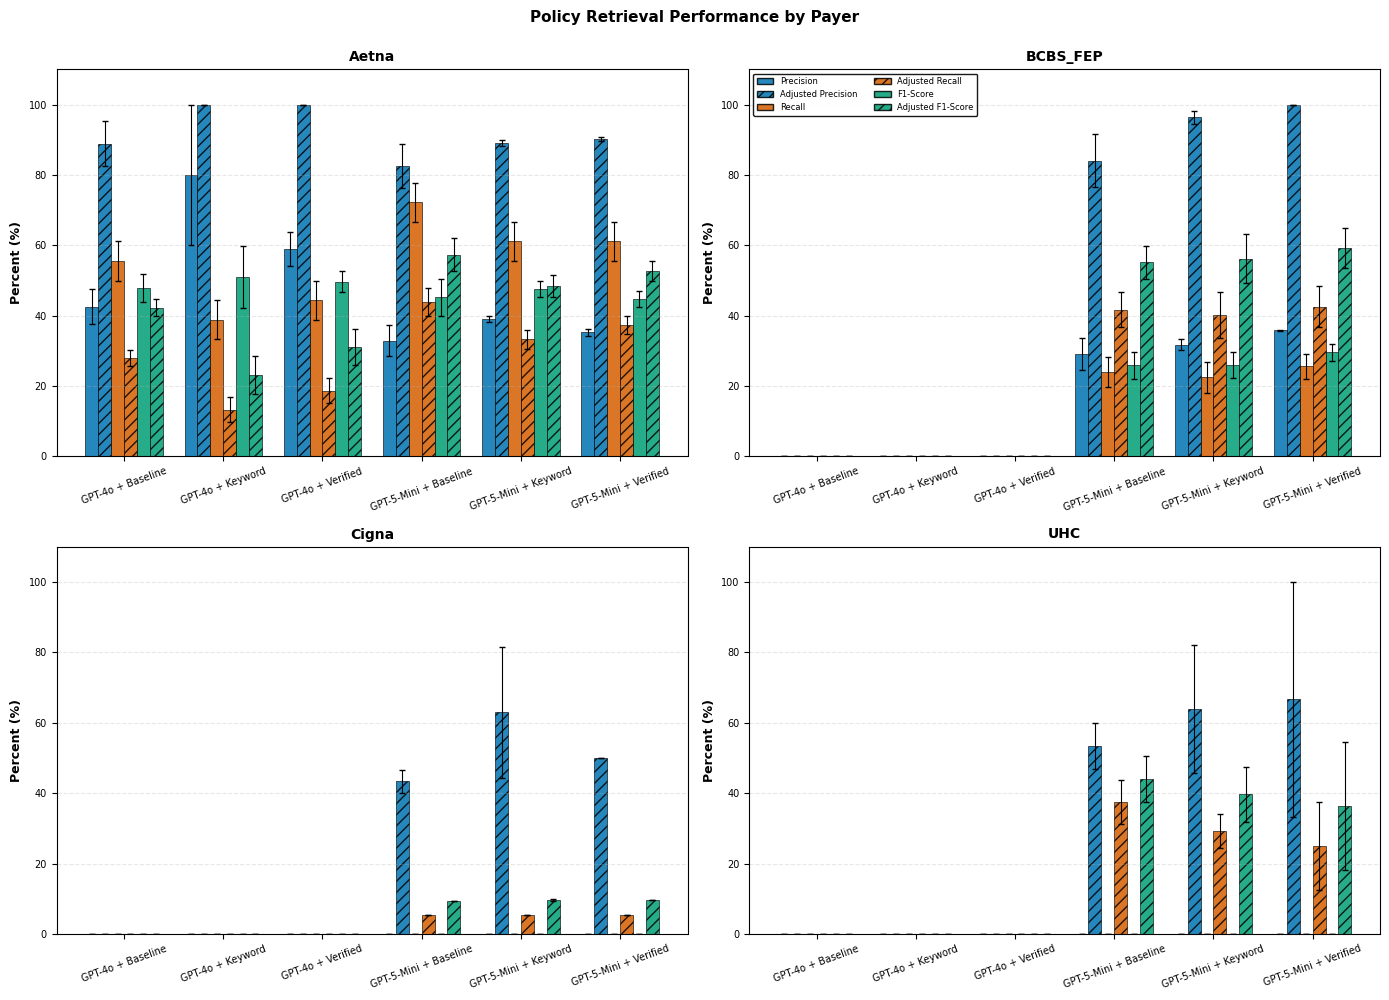

Metric                    GPT-4o  GPT-5-Mini
Precision                  15.12       17.01
Adjusted Precision         24.07       73.56
Recall                     11.57       22.21
Adjusted Recall             5.00       28.89
F1-Score                   12.37       18.26
Adjusted F1-Score           8.06       39.81


In [7]:
def calc_payer_stats(payer_df):
    model_prompts = payer_df['model_prompt'].unique()
    results = []
    
    def to_float(series):
        return series.astype(str).str.replace('%', '', regex=False).astype(float)
    
    for mp in model_prompts:
        group = payer_df[payer_df['model_prompt'] == mp]
        
        precision = to_float(group['Precision'])
        adj_precision = to_float(group['Adjusted_Precision'])
        recall = to_float(group['Recall'])
        adj_recall = to_float(group['Adjusted_Recall'])
        f1 = to_float(group['F1-Score'])
        adj_f1 = to_float(group['Adjusted_F1-Score'])
        
        results.append({
            'model_prompt': mp,
            'precision_mean': np.mean(precision),
            'precision_se': stats.sem(precision),
            'adj_precision_mean': np.mean(adj_precision),
            'adj_precision_se': stats.sem(adj_precision),
            'recall_mean': np.mean(recall),
            'recall_se': stats.sem(recall),
            'adj_recall_mean': np.mean(adj_recall),
            'adj_recall_se': stats.sem(adj_recall),
            'f1_mean': np.mean(f1),
            'f1_se': stats.sem(f1),
            'adj_f1_mean': np.mean(adj_f1),
            'adj_f1_se': stats.sem(adj_f1)
        })
    
    return results

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

base_colors = ['#0072B2', '#D55E00', '#009E73'] 
colors = [base_colors[0], base_colors[0], base_colors[1], base_colors[1], base_colors[2], base_colors[2]]
labels = ['Precision', 'Adjusted Precision', 'Recall', 'Adjusted Recall', 'F1-Score', 'Adjusted F1-Score']
hatches = ['', '///', '', '///', '', '///']

for idx, payer in enumerate(payers):
    ax = axes[idx]
    
    payer_df = df_policy[df_policy['Payer'] == payer]
    
    payer_stats = calc_payer_stats(payer_df)
    
    precision_means = [s['precision_mean'] for s in payer_stats]
    precision_ses = [s['precision_se'] for s in payer_stats]
    adj_precision_means = [s['adj_precision_mean'] for s in payer_stats]
    adj_precision_ses = [s['adj_precision_se'] for s in payer_stats]
    recall_means = [s['recall_mean'] for s in payer_stats]
    recall_ses = [s['recall_se'] for s in payer_stats]
    adj_recall_means = [s['adj_recall_mean'] for s in payer_stats]
    adj_recall_ses = [s['adj_recall_se'] for s in payer_stats]
    f1_means = [s['f1_mean'] for s in payer_stats]
    f1_ses = [s['f1_se'] for s in payer_stats]
    adj_f1_means = [s['adj_f1_mean'] for s in payer_stats]
    adj_f1_ses = [s['adj_f1_se'] for s in payer_stats]
    
    x = np.arange(len(payer_stats))
    width = 0.13  
    
    data_list = [
        (precision_means, precision_ses),
        (adj_precision_means, adj_precision_ses),
        (recall_means, recall_ses),
        (adj_recall_means, adj_recall_ses),
        (f1_means, f1_ses),
        (adj_f1_means, adj_f1_ses)
    ]
    
    metrics = ['Precision', 'Adj Precision', 'Recall', 'Adj Recall', 'F1', 'Adj F1']
    mean_keys = ['precision_mean', 'adj_precision_mean', 'recall_mean', 'adj_recall_mean', 'f1_mean', 'adj_f1_mean']
    se_keys   = ['precision_se',   'adj_precision_se',   'recall_se',   'adj_recall_se',   'f1_se',   'adj_f1_se']

    print(f"  {payer}")

    header = f"{'Metric':<18}" + "".join(f"{s['model_prompt']:>12}" for s in payer_stats)
    print(header)
    print("-" * 70)

    for metric, mk, sk in zip(metrics, mean_keys, se_keys):
        row = f"{metric:<18}"
        for s in payer_stats:
            row += f"{s[mk]:>8.1f}±{s[sk]:<4.1f}"
        print(row)


    for i, ((means, ses), label, color, hatch) in enumerate(zip(data_list, labels, colors, hatches)):
        offset = (i - 2.5) * width
        bars = ax.bar(x + offset, means, width, label=label, color=color, 
                     alpha=0.85, hatch=hatch, edgecolor='black', linewidth=0.5,
                     yerr=ses, error_kw={'ecolor': 'black', 'capsize': 2, 'elinewidth': 0.8})
    
    ax.set_ylabel('Percent (%)', fontsize=9, fontweight='bold')
    ax.set_title(payer, fontsize=10, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([s['model_prompt'] for s in payer_stats], 
                       fontsize=7, rotation=20, ha='center')
    ax.tick_params(axis='y', labelsize=7)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(0, 110)
    
    if payer == 'BCBS_FEP':
        from matplotlib.patches import Rectangle
    
        legend_elements = []
        for label, color, hatch in zip(labels, colors, hatches):
            legend_elements.append(Rectangle((0, 0), 1, 1, fc=color, ec='black', 
                                         hatch=hatch, alpha=0.85, label=label))
    
            ax.legend(handles=legend_elements, fontsize=6, loc='upper left', ncol=2,
                framealpha=0.9, edgecolor='black')

plt.suptitle('Policy Retrieval Performance by Payer', fontsize=11, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('Figure2.pdf', dpi=300, bbox_inches='tight')
plt.show()

def to_float(series):
    return series.astype(str).str.replace('%', '', regex=False).astype(float)

gpt4o = df_policy[df_policy['model_prompt'].str.contains('GPT-4o')]
gpt5mini = df_policy[df_policy['model_prompt'].str.contains('GPT-5-Mini')]

models = ['GPT-4o', 'GPT-5-Mini']
dfs = [gpt4o, gpt5mini]

print(f"{'Metric':<20}{'GPT-4o':>12}{'GPT-5-Mini':>12}")

for metric in ['Precision', 'Adjusted_Precision', 'Recall', 'Adjusted_Recall', 'F1-Score', 'Adjusted_F1-Score']:
    row = f"{metric.replace('_', ' '):<20}"
    for d in dfs:
        vals = to_float(d[metric])
        row += f"{np.mean(vals):>12.2f}"
    print(row)

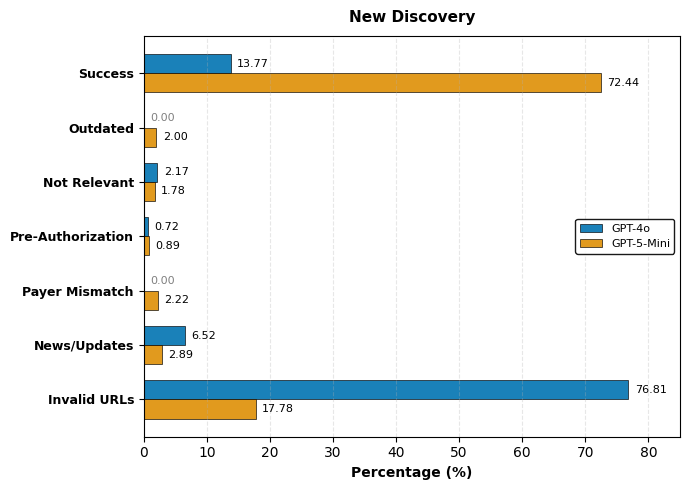

In [10]:
category_labels = [
    'Success',
    'Outdated',
    'Not Relevant',
    'Pre-Authorization',
    'Payer Mismatch',
    'News/Updates',
    'Invalid URLs'
]

gpt4o = [13.77, 0.00, 2.17, 0.72, 0.00, 6.52, 76.81]
gpt5_mini = [72.44, 2.00, 1.78, 0.89, 2.22, 2.89, 17.78]


fig, ax = plt.subplots(figsize=(7, 5))
y = np.arange(len(category_labels))
height = 0.35

colors = ['#0173B2', '#DE8F05']
models = ['GPT-4o', 'GPT-5-Mini']
data = [gpt4o, gpt5_mini]

for idx, (model_data, color, model_name) in enumerate(zip(data, colors, models)):
    offset = (idx - 0.5) * height
    bars = ax.barh(y + offset, model_data, height, label=model_name, 
                   color=color, alpha=0.9, edgecolor='black', linewidth=0.5)
    
    for bar, value in zip(bars, model_data):
        if value > 0:
            width = bar.get_width()
            ax.text(width + 1, bar.get_y() + bar.get_height()/2.,
                f'{value:.2f}', ha='left', va='center', fontsize=8)
        else:
            ax.text(1, bar.get_y() + bar.get_height()/2.,
                f'{value:.2f}', ha='left', va='center', fontsize=8, color='gray')

ax.set_xlabel('Percentage (%)', fontsize=10, fontweight='bold')
ax.set_title('New Discovery', fontsize=11, fontweight='bold', pad=10)
ax.set_yticks(y)
ax.set_yticklabels(category_labels, fontsize=9, fontweight='bold')
ax.legend(fontsize=8, loc='center right', framealpha=0.9, edgecolor='black')
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_xlim(0, 85)
ax.invert_yaxis()  

plt.tight_layout()
plt.savefig('Figure3.pdf', dpi=300, bbox_inches='tight')
plt.show()

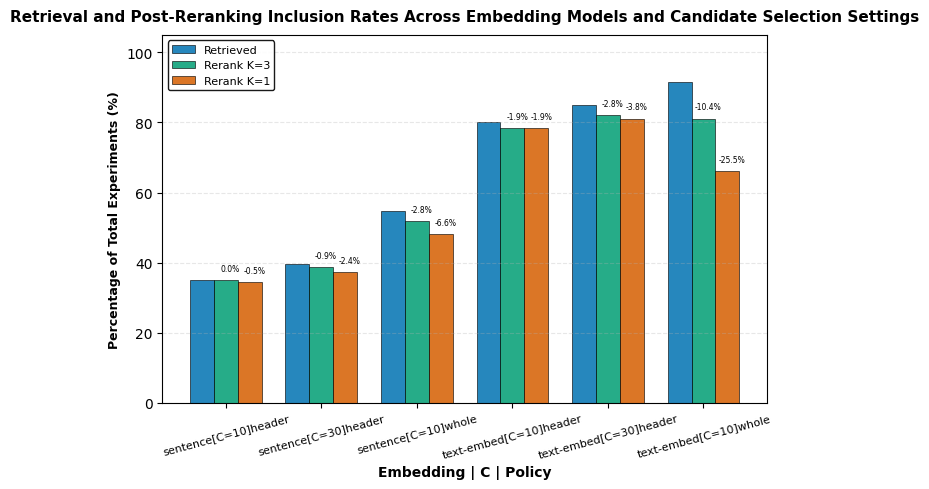

In [11]:
result_list = []

for (model, input_type, c), group in df_match.groupby(['Embedding_Model', 'Input_Type', 'Retrieval_C']):
    retrieved_rate = (group['Retrieved_Success'].iloc[0] / group['Total_Experiment'].iloc[0]) * 100
    
    k1_data = group[group['Rerank_K'] == 1]
    k3_data = group[group['Rerank_K'] == 3]
    
    rerank_k1_rate = (k1_data['Rerank_Success'].iloc[0] / k1_data['Total_Experiment'].iloc[0]) * 100 if len(k1_data) > 0 else np.nan
    rerank_k3_rate = (k3_data['Rerank_Success'].iloc[0] / k3_data['Total_Experiment'].iloc[0]) * 100 if len(k3_data) > 0 else np.nan
    
    result_list.append({
        'Embedding_Model': model,
        'Input_Type': input_type,
        'Retrieval_C': c,
        'Retrieved_Rate': retrieved_rate,
        'Rerank_K1_Rate': rerank_k1_rate,
        'Rerank_K3_Rate': rerank_k3_rate
    })

grouped = pd.DataFrame(result_list)

def create_label(row):
    model = 'sentence' if 'Sentence' in row['Embedding_Model'] else 'text-embed'
    input_type = row['Input_Type'].lower()
    c = int(row['Retrieval_C'])
    return f"{model}[C={c}]{input_type}"

grouped['label'] = grouped.apply(create_label, axis=1)

order = ['sentence[C=10]header', 'sentence[C=30]header', 'sentence[C=10]whole',
         'text-embed[C=10]header', 'text-embed[C=30]header', 'text-embed[C=10]whole']
grouped['order'] = grouped['label'].apply(lambda x: order.index(x) if x in order else 999)
grouped = grouped.sort_values('order')

fig, ax = plt.subplots(figsize=(7, 5))

x = np.arange(len(grouped))
width = 0.25

colors = ['#0072B2', '#009E73', '#D55E00'] 

retrieved = ax.bar(x - width, grouped['Retrieved_Rate'], width, 
                   label='Retrieved', color=colors[0], alpha=0.85, edgecolor='black', linewidth=0.5)
rerank_k3 = ax.bar(x, grouped['Rerank_K3_Rate'], width, 
                   label='Rerank K=3', color=colors[1], alpha=0.85, edgecolor='black', linewidth=0.5)
rerank_k1 = ax.bar(x + width, grouped['Rerank_K1_Rate'], width, 
                   label='Rerank K=1', color=colors[2], alpha=0.85, edgecolor='black', linewidth=0.5)


def add_value_labels(bars, values, reference_values, show_label=True):
    for bar, val, ref_val in zip(bars, values, reference_values):
        if not np.isnan(val) and show_label:
            height = bar.get_height()
            diff = val - ref_val
            label_text = f'{diff:+.1f}%' if diff != 0 else f'{diff:.1f}%'
            ax.text(bar.get_x() + bar.get_width() * 0.7, height + 2,
                   label_text, ha='center', va='bottom', fontsize=5.5)

add_value_labels(retrieved, grouped['Retrieved_Rate'], grouped['Retrieved_Rate'], show_label=False)
add_value_labels(rerank_k3, grouped['Rerank_K3_Rate'], grouped['Retrieved_Rate'])
add_value_labels(rerank_k1, grouped['Rerank_K1_Rate'], grouped['Retrieved_Rate'])

ax.set_ylabel('Percentage of Total Experiments (%)', fontsize=9, fontweight='bold')
ax.set_xlabel('Embedding | C | Policy', fontsize=10, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(grouped['label'], fontsize=8, rotation=15, ha='center')
ax.set_ylim(0, 105)
ax.legend(fontsize=8, loc='upper left', framealpha=0.9, edgecolor='black')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.title('Retrieval and Post-Reranking Inclusion Rates Across Embedding Models and Candidate Selection Settings', fontsize=11, fontweight='bold', pad=10)
plt.tight_layout()
plt.savefig('Figure4.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
def se(x):
    return x.std() / np.sqrt(len(x))

df_qna['mode_case'] = df_qna.apply(lambda row: 
    'baseline' if row['mode'] == 'baseline' 
    else f"rag_{row['case_type']}", axis=1)

# Accuracy와 Adjusted Accuracy (matched 포함)
iter_means = df_qna.groupby(['matched', 'mode_case', 'iteration']).agg({
    'case_id': 'count',
    'accuracy': 'mean',
    'adjusted_accuracy': 'mean',
    'adjusted_total': 'mean'
})

summary_iter = iter_means.groupby(['matched', 'mode_case']).agg({
    'case_id': 'sum',
    'accuracy': ['mean', se],
    'adjusted_accuracy': ['mean', se],
    'adjusted_total': ['mean', se]
}).round(2)
summary_iter.columns = ['Count', 'Avg Accuracy (%)', 'Accuracy SE',
                        'Avg Adjusted Accuracy (%)', 'Adjusted Accuracy SE',
                        'Adjusted Total', 'Adjusted Total SE']

# Abstention Rate (matched 무시, 전체)
total_questions_per_case = 9
iter_means_abst = df_qna.groupby(['mode_case', 'iteration']).agg({
    'case_id': 'count',
    'not_answerable_count': 'sum'
})
iter_means_abst['abstention_rate'] = (iter_means_abst['not_answerable_count'] / 
                                       (iter_means_abst['case_id'] * total_questions_per_case)) * 100

abstention_summary = iter_means_abst.groupby('mode_case').agg({
    'abstention_rate': ['mean', se]
}).round(2)
abstention_summary.columns = ['Avg Abstention Rate (%)', 'Abstention Rate SE']
print(abstention_summary)
abstention_summary = abstention_summary.reset_index()

                   Avg Abstention Rate (%)  Abstention Rate SE
mode_case                                                     
baseline                              0.53                0.16
rag_all_correct                       1.52                0.09
rag_all_incorrect                     2.43                0.28


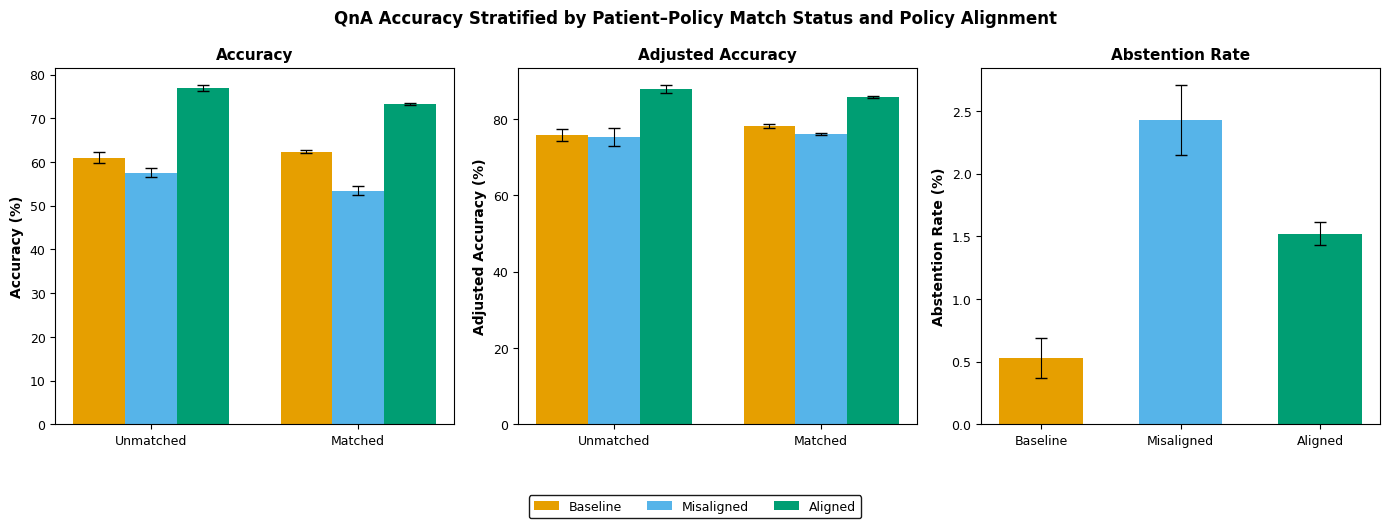

In [10]:
data = summary_iter.reset_index()

unmatched_data = data[data['matched'] == 0].sort_values('mode_case')
matched_data = data[data['matched'] == 1].sort_values('mode_case')

color_baseline = '#E69F00'      # Orange
color_rag_incorrect = '#56B4E9' # Sky Blue
color_rag_correct = '#009E73'   # Green

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))
fig.suptitle('QnA Accuracy Stratified by Patient–Policy Match Status and Policy Alignment', 
             fontsize=12, fontweight='bold')

width = 0.25
x_pos = np.arange(2) 

# ========== ax1: Accuracy ==========
baseline_acc = [unmatched_data[unmatched_data['mode_case']=='baseline']['Avg Accuracy (%)'].values[0],
                matched_data[matched_data['mode_case']=='baseline']['Avg Accuracy (%)'].values[0]]
baseline_acc_se = [unmatched_data[unmatched_data['mode_case']=='baseline']['Accuracy SE'].values[0],
                   matched_data[matched_data['mode_case']=='baseline']['Accuracy SE'].values[0]]

ax1.bar(x_pos - width, baseline_acc, width,
        yerr=baseline_acc_se, capsize=5,
        label='Baseline', color=color_baseline,
        error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.8})

rag_incorr_acc = [unmatched_data[unmatched_data['mode_case']=='rag_all_incorrect']['Avg Accuracy (%)'].values[0],
                  matched_data[matched_data['mode_case']=='rag_all_incorrect']['Avg Accuracy (%)'].values[0]]
rag_incorr_acc_se = [unmatched_data[unmatched_data['mode_case']=='rag_all_incorrect']['Accuracy SE'].values[0],
                     matched_data[matched_data['mode_case']=='rag_all_incorrect']['Accuracy SE'].values[0]]  # ✅ 수정

ax1.bar(x_pos, rag_incorr_acc, width,
        yerr=rag_incorr_acc_se, capsize=5,
        label='Misaligned', color=color_rag_incorrect,
        error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.8})

rag_corr_acc = [unmatched_data[unmatched_data['mode_case']=='rag_all_correct']['Avg Accuracy (%)'].values[0],
                matched_data[matched_data['mode_case']=='rag_all_correct']['Avg Accuracy (%)'].values[0]]
rag_corr_acc_se = [unmatched_data[unmatched_data['mode_case']=='rag_all_correct']['Accuracy SE'].values[0],
                   matched_data[matched_data['mode_case']=='rag_all_correct']['Accuracy SE'].values[0]]

ax1.bar(x_pos + width, rag_corr_acc, width,
        yerr=rag_corr_acc_se, capsize=5,
        label='Aligned', color=color_rag_correct,
        error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.8})

ax1.set_ylabel('Accuracy (%)', fontsize=10, fontweight='bold')
ax1.set_title('Accuracy', fontsize=11, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(['Unmatched', 'Matched'], fontsize=9)
ax1.tick_params(axis='y', labelsize=9)

# ========== ax2: Adjusted Accuracy ==========
baseline_adj = [unmatched_data[unmatched_data['mode_case']=='baseline']['Avg Adjusted Accuracy (%)'].values[0],
                matched_data[matched_data['mode_case']=='baseline']['Avg Adjusted Accuracy (%)'].values[0]]
baseline_adj_se = [unmatched_data[unmatched_data['mode_case']=='baseline']['Adjusted Accuracy SE'].values[0],
                   matched_data[matched_data['mode_case']=='baseline']['Adjusted Accuracy SE'].values[0]]

ax2.bar(x_pos - width, baseline_adj, width,
        yerr=baseline_adj_se, capsize=5,
        label='Baseline', color=color_baseline,
        error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.8})

rag_incorr_adj = [unmatched_data[unmatched_data['mode_case']=='rag_all_incorrect']['Avg Adjusted Accuracy (%)'].values[0],
                  matched_data[matched_data['mode_case']=='rag_all_incorrect']['Avg Adjusted Accuracy (%)'].values[0]]
rag_incorr_adj_se = [unmatched_data[unmatched_data['mode_case']=='rag_all_incorrect']['Adjusted Accuracy SE'].values[0],
                     matched_data[matched_data['mode_case']=='rag_all_incorrect']['Adjusted Accuracy SE'].values[0]]

ax2.bar(x_pos, rag_incorr_adj, width,
        yerr=rag_incorr_adj_se, capsize=5,
        label='Misaligned', color=color_rag_incorrect,
        error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.8})

rag_corr_adj = [unmatched_data[unmatched_data['mode_case']=='rag_all_correct']['Avg Adjusted Accuracy (%)'].values[0],
                matched_data[matched_data['mode_case']=='rag_all_correct']['Avg Adjusted Accuracy (%)'].values[0]]
rag_corr_adj_se = [unmatched_data[unmatched_data['mode_case']=='rag_all_correct']['Adjusted Accuracy SE'].values[0],
                   matched_data[matched_data['mode_case']=='rag_all_correct']['Adjusted Accuracy SE'].values[0]]

ax2.bar(x_pos + width, rag_corr_adj, width,
        yerr=rag_corr_adj_se, capsize=5,
        label='Aligned', color=color_rag_correct,
        error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.8})

ax2.set_ylabel('Adjusted Accuracy (%)', fontsize=10, fontweight='bold')
ax2.set_title('Adjusted Accuracy', fontsize=11, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(['Unmatched', 'Matched'], fontsize=9)
ax2.tick_params(axis='y', labelsize=9)

# ========== ax3: Abstention Rate ==========
x_pos_abst = np.arange(3)  # 3개 bar

baseline_abst = abstention_summary[abstention_summary['mode_case']=='baseline']['Avg Abstention Rate (%)'].values[0]
baseline_abst_se = abstention_summary[abstention_summary['mode_case']=='baseline']['Abstention Rate SE'].values[0]

rag_incorr_abst = abstention_summary[abstention_summary['mode_case']=='rag_all_incorrect']['Avg Abstention Rate (%)'].values[0]
rag_incorr_abst_se = abstention_summary[abstention_summary['mode_case']=='rag_all_incorrect']['Abstention Rate SE'].values[0]

rag_corr_abst = abstention_summary[abstention_summary['mode_case']=='rag_all_correct']['Avg Abstention Rate (%)'].values[0]
rag_corr_abst_se = abstention_summary[abstention_summary['mode_case']=='rag_all_correct']['Abstention Rate SE'].values[0]

ax3.bar(x_pos_abst, 
        [baseline_abst, rag_incorr_abst, rag_corr_abst], 
        width=0.6,
        yerr=[baseline_abst_se, rag_incorr_abst_se, rag_corr_abst_se],
        capsize=5,
        color=[color_baseline, color_rag_incorrect, color_rag_correct],
        error_kw={'ecolor': 'black', 'capsize': 4, 'elinewidth': 0.8})

ax3.set_ylabel('Abstention Rate (%)', fontsize=10, fontweight='bold')
ax3.set_title('Abstention Rate', fontsize=11, fontweight='bold')
ax3.set_xticks(x_pos_abst)
ax3.set_xticklabels(['Baseline', 'Misaligned', 'Aligned'], fontsize=9)
ax3.tick_params(axis='y', labelsize=9)

# ========== Legend ==========
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05),
           fontsize=9, framealpha=0.9, edgecolor='black', ncol=3)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('Figure5.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
def calc_question_accuracy(df, ground_truth, questions):
    iterations = df['iteration'].unique()
    
    basic_mean = {}
    basic_se = {}
    adj_mean = {}
    adj_se = {}
    
    for q in questions:
        answer_col = f'{q}_answer'
        
        basic_by_iter = []
        adj_by_iter = []

        for iteration in iterations:
            iter_df = df[df['iteration'] == iteration]
        
            # Basic accuracy
            correct = 0
            total = 0
        
            # Adjusted accuracy
            adj_correct = 0
            adj_total = 0
        
            excluded = ["Not Specified", "Question Unclear", "Not Answerable"]
        
            for _, row in iter_df.iterrows():
                case_id = row['case_id']
                if case_id not in ground_truth:
                    continue
            
                pred = str(row[answer_col]).strip()
                true = str(ground_truth[case_id][q]).strip()
            
                # Basic
                total += 1
                if pred == true:
                    correct += 1
            
                # Adjusted
                if true not in excluded and pred not in excluded:
                    adj_total += 1
                    if pred == true:
                        adj_correct += 1
        
            basic_by_iter.append((correct / total * 100) if total > 0 else np.nan)
            adj_by_iter.append((adj_correct / adj_total * 100) if adj_total > 0 else np.nan)

        basic_mean[q] = np.mean(basic_by_iter)
        basic_se[q] = np.std(basic_by_iter, ddof=1) / np.sqrt(len(basic_by_iter))
        
        adj_mean[q] = np.mean(adj_by_iter)
        adj_se[q] = np.std(adj_by_iter, ddof=1) / np.sqrt(len(adj_by_iter))
    
    return basic_mean, basic_se, adj_mean, adj_se  

def add_value_labels(ax, bars, se_values=None):
    for i, bar in enumerate(bars):
        value = bar.get_width()
        
        if np.isnan(value):
            ax.text(5, bar.get_y() + bar.get_height()/2, 
                'NA', 
                ha='left', va='center', fontsize=8, 
                fontweight='bold', color='gray')
            continue
        
        se = se_values[i] if se_values else 0
        x_pos = value + se + 2
        ax.text(x_pos, bar.get_y() + bar.get_height()/2, 
            f'{value:.2f}', 
            ha='left', va='center', fontsize=8)

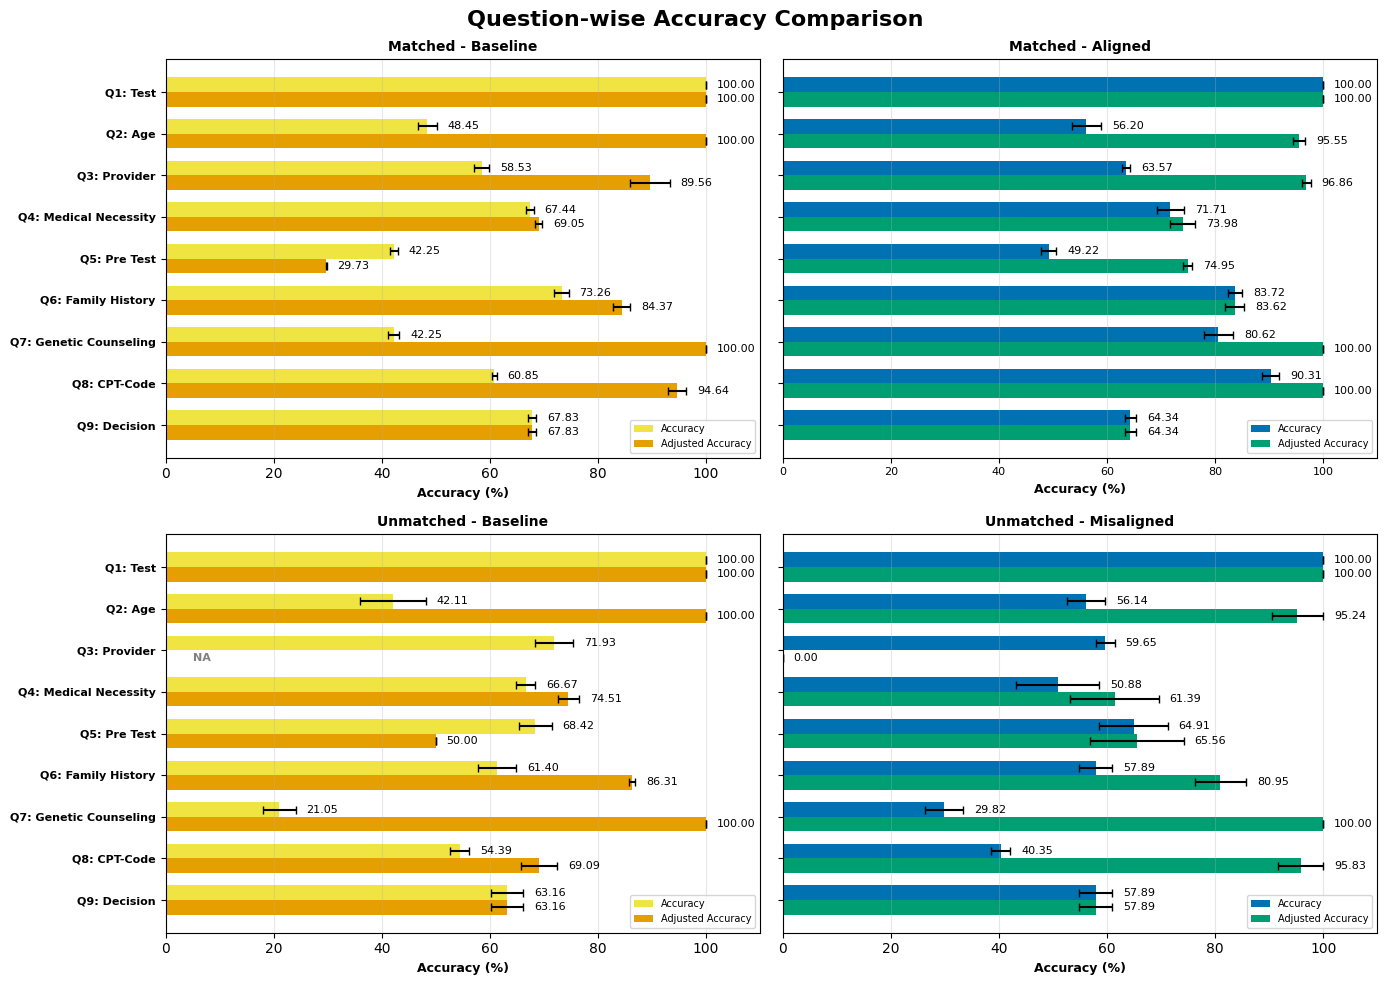

In [7]:
filtered_df = df_qna[
     (((df_qna['mode'] == 'rag') & (df_qna['case_type'] == 'all_correct') & (df_qna['matched'] == 1)) |
     ((df_qna['mode'] == 'baseline') & (df_qna['matched'] == 1))) |
     (((df_qna['mode'] == 'rag') & (df_qna['case_type'] == 'all_incorrect') & (df_qna['matched'] == 0)) |
     ((df_qna['mode'] == 'baseline') & (df_qna['matched'] == 0)))
]
rename_map = {f'Q{i}_answer': f'Q{i+1}_answer' for i in range(9)}
filtered_df = filtered_df.rename(columns=rename_map)

ground_truth = {
    case_id: {f'Q{int(q[1:])+1}': v for q, v in qs.items() if q.startswith('Q') and q[1:].isdigit()}
    for case_id, qs in ground_truth.items()
}

questions = [f'Q{i}' for i in range(1, 10)]
q_labels = ['Q1: Test', 'Q2: Age', 'Q3: Provider', 'Q4: Medical Necessity', 
            'Q5: Pre Test', 'Q6: Family History', 'Q7: Genetic Counseling', 
            'Q8: CPT-Code', 'Q9: Decision']

matched_baseline = filtered_df[(filtered_df['mode'] == 'baseline') & (filtered_df['matched'] == 1)]
matched_rag = filtered_df[(filtered_df['mode'] == 'rag') & (filtered_df['matched'] == 1)]
unmatched_baseline = filtered_df[(filtered_df['mode'] == 'baseline') & (filtered_df['matched'] == 0)]
unmatched_rag = filtered_df[(filtered_df['mode'] == 'rag') & (filtered_df['matched'] == 0)]

mb_basic, mb_basic_se, mb_adj, mb_adj_se = calc_question_accuracy(matched_baseline, ground_truth, questions)
mr_basic, mr_basic_se, mr_adj, mr_adj_se = calc_question_accuracy(matched_rag, ground_truth, questions)
umb_basic, umb_basic_se, umb_adj, umb_adj_se = calc_question_accuracy(unmatched_baseline, ground_truth, questions)
umr_basic, umr_basic_se, umr_adj, umr_adj_se = calc_question_accuracy(unmatched_rag, ground_truth, questions)

# Figure 생성
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Question-wise Accuracy Comparison', 
             fontsize=16, fontweight='bold')

# Color-blind friendly colors (새로운 조합)
color_baseline_light = '#F0E442'  # Yellow (basic)
color_baseline_dark = '#E69F00'   # Orange (adjusted)
color_rag_light = '#0072B2'       # Blue (basic)
color_rag_dark = '#009E73'        # Bluish Green (adjusted)

y_pos = np.arange(len(questions))
width = 0.35

# Matched-Baseline
ax = axes[0, 0]
bars1 = ax.barh(y_pos - width/2, [mb_basic[q] for q in questions], width,
                xerr=[mb_basic_se[q] for q in questions],  
                label='Accuracy', color=color_baseline_light,
                error_kw={'linewidth': 1.5, 'ecolor': 'black', 'capsize': 3}) 

bars2 = ax.barh(y_pos + width/2, [mb_adj[q] for q in questions], width,
                xerr=[mb_adj_se[q] for q in questions],  
                label='Adjusted Accuracy', color=color_baseline_dark,
                error_kw={'linewidth': 1.5, 'ecolor': 'black', 'capsize': 3})

add_value_labels(ax, bars1, [mb_basic_se[q] for q in questions])
add_value_labels(ax, bars2, [mb_adj_se[q] for q in questions])
ax.set_yticks(y_pos)
ax.set_yticklabels(q_labels, fontweight='bold', fontsize=8)
ax.invert_yaxis()
ax.set_xlabel('Accuracy (%)', fontsize=9, fontweight='bold')
ax.set_title('Matched - Baseline', fontsize=10, fontweight='bold')
ax.legend(loc='lower right', fontsize=7)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 110)

# Matched-RAG
ax = axes[0, 1]
bars1 = ax.barh(y_pos - width/2, [mr_basic[q] for q in questions], width,
                xerr=[mr_basic_se[q] for q in questions],  
                label='Accuracy', color=color_rag_light,
                error_kw={'linewidth': 1.5, 'ecolor': 'black', 'capsize': 3}) 

bars2 = ax.barh(y_pos + width/2, [mr_adj[q] for q in questions], width,
                xerr=[mr_adj_se[q] for q in questions],  
                label='Adjusted Accuracy', color=color_rag_dark,
                error_kw={'linewidth': 1.5, 'ecolor': 'black', 'capsize': 3})

add_value_labels(ax, bars1, [mr_basic_se[q] for q in questions])
add_value_labels(ax, bars2, [mr_adj_se[q] for q in questions])
ax.set_yticks(y_pos)
ax.set_yticklabels([])
ax.invert_yaxis()
ax.set_xlabel('Accuracy (%)', fontsize=9, fontweight='bold')
ax.set_title('Matched - Aligned', fontsize=10, fontweight='bold')
ax.tick_params(axis='x', labelsize=8)
ax.legend(loc='lower right', fontsize=7)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 110)

# Unmatched-Baseline
ax = axes[1, 0]
bars1 = ax.barh(y_pos - width/2, [umb_basic[q] for q in questions], width,
                xerr=[umb_basic_se[q] for q in questions],  
                label='Accuracy', color=color_baseline_light,
                error_kw={'linewidth': 1.5, 'ecolor': 'black', 'capsize': 3}) 

bars2 = ax.barh(y_pos + width/2, [umb_adj[q] for q in questions], width,
                xerr=[umb_adj_se[q] for q in questions],  
                label='Adjusted Accuracy', color=color_baseline_dark,
                error_kw={'linewidth': 1.5, 'ecolor': 'black', 'capsize': 3})

# Unmatched-Baseline
add_value_labels(ax, bars1, [umb_basic_se[q] for q in questions])
add_value_labels(ax, bars2, [umb_adj_se[q] for q in questions])
ax.set_yticks(y_pos)
ax.set_yticklabels(q_labels, fontweight='bold', fontsize=8)
ax.invert_yaxis()
ax.set_xlabel('Accuracy (%)', fontsize=9, fontweight='bold')
ax.set_title('Unmatched - Baseline', fontsize=10, fontweight='bold')
ax.legend(loc='lower right', fontsize=7)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 110)

# Unmatched-RAG
ax = axes[1, 1]
bars1 = ax.barh(y_pos - width/2, [umr_basic[q] for q in questions], width,
                xerr=[umr_basic_se[q] for q in questions],  
                label='Accuracy', color=color_rag_light,
                error_kw={'linewidth': 1.5, 'ecolor': 'black', 'capsize': 3}) 

bars2 = ax.barh(y_pos + width/2, [umr_adj[q] for q in questions], width,
                xerr=[umr_adj_se[q] for q in questions],  
                label='Adjusted Accuracy', color=color_rag_dark,
                error_kw={'linewidth': 1.5, 'ecolor': 'black', 'capsize': 3})

add_value_labels(ax, bars1, [umr_basic_se[q] for q in questions])
add_value_labels(ax, bars2, [umr_adj_se[q] for q in questions])
ax.set_yticks(y_pos)
ax.set_yticklabels([])
ax.invert_yaxis()
ax.set_xlabel('Accuracy (%)', fontsize=9, fontweight='bold')
ax.set_title('Unmatched - Misaligned', fontsize=10, fontweight='bold')
ax.legend(loc='lower right', fontsize=7)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 110)

plt.tight_layout()
plt.savefig('Figure6.pdf', dpi=300, bbox_inches='tight')
plt.show()

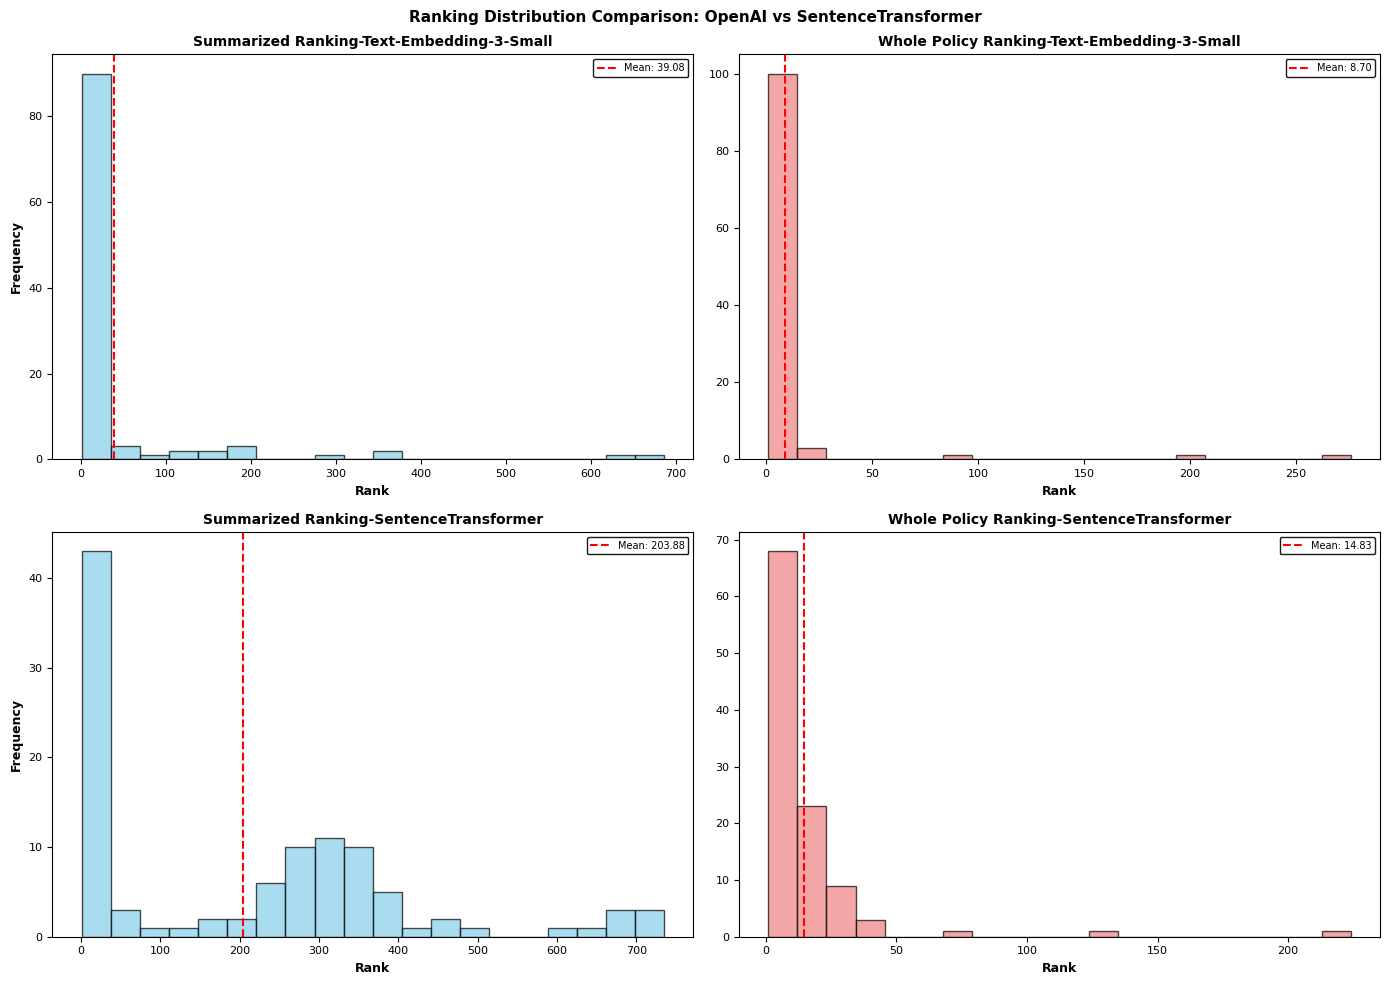

In [16]:
df_init_openai = pd.read_csv("/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/initial_match_rank_openai.csv")
df_init_openai = df_init_openai[df_init_openai['case_id'] != 'Mean_Rank']
df_sentence = pd.read_csv("/home/cptaswadu/new-rescue/RESCUE-n8n/eval/insurance/results/LLM_QnA/RAG/final/initial_match_rank.csv")
df_sentence = df_sentence[df_sentence['case_id'] != 'Mean_Rank']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Ranking Distribution Comparison: OpenAI vs SentenceTransformer', 
             fontsize=11, fontweight='bold', y=0.98)


# Row 1: OpenAI
axes[0,0].hist(df_init_openai['rank_header'].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(df_init_openai['rank_header'].mean(), color='red', linestyle='--', label=f'Mean: {df_init_openai["rank_header"].mean():.2f}')
axes[0,0].set_xlabel('Rank', fontsize=9, fontweight='bold')
axes[0,0].set_ylabel('Frequency', fontsize=9, fontweight='bold')
axes[0,0].set_title('Summarized Ranking-Text-Embedding-3-Small', fontsize=10, fontweight='bold')
axes[0,0].tick_params(axis='both', labelsize=8)
axes[0,0].legend(fontsize=7, framealpha=0.9, edgecolor='black')

axes[0,1].hist(df_init_openai['rank_policy'].dropna(), bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].axvline(df_init_openai['rank_policy'].mean(), color='red', linestyle='--', label=f'Mean: {df_init_openai["rank_policy"].mean():.2f}')
axes[0,1].set_xlabel('Rank', fontsize=9, fontweight='bold')
axes[0,1].set_title('Whole Policy Ranking-Text-Embedding-3-Small', fontsize=10, fontweight='bold')
axes[0,1].tick_params(axis='both', labelsize=8)
axes[0,1].legend(fontsize=7, framealpha=0.9, edgecolor='black')

# Row 2: SentenceTransformer
axes[1,0].hist(df_sentence['rank_header'].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,0].axvline(df_sentence['rank_header'].mean(), color='red', linestyle='--', label=f'Mean: {df_sentence["rank_header"].mean():.2f}')
axes[1,0].set_xlabel('Rank', fontsize=9, fontweight='bold')
axes[1,0].set_ylabel('Frequency', fontsize=9, fontweight='bold')
axes[1,0].set_title('Summarized Ranking-SentenceTransformer', fontsize=10, fontweight='bold')
axes[1,0].tick_params(axis='both', labelsize=8)
axes[1,0].legend(fontsize=7, framealpha=0.9, edgecolor='black')

axes[1,1].hist(df_sentence['rank_policy'].dropna(), bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1,1].axvline(df_sentence['rank_policy'].mean(), color='red', linestyle='--', label=f'Mean: {df_sentence["rank_policy"].mean():.2f}')
axes[1,1].set_xlabel('Rank', fontsize=9, fontweight='bold')
axes[1,1].set_title('Whole Policy Ranking-SentenceTransformer', fontsize=10, fontweight='bold')
axes[1,1].tick_params(axis='both', labelsize=8)
axes[1,1].legend(fontsize=7, framealpha=0.9, edgecolor='black')

plt.tight_layout()
plt.savefig('S_figure1.pdf', dpi=300, bbox_inches='tight')
plt.show()